# Notebook to compare run1.2i errors to Zeljko error model

For DC1 we used the error model that is in Ivezic et al. https://arxiv.org/abs/0805.2366
see equations 4-6 and table 2 for parameters.  We want to check how this model compares to the errors that are coming out of DMstack so that we can be sure that the errors that we generate for cosmoDC2 data are at least similar to the errors coming out of the Stack.

NOTE: Looking at the PhotoZDC1/src/photErrorModel.py (line 341) source code, Alex and/or I tried to be clever and added a `sigmaRand = = 2.5*math.log10(1.+sigmaRand)` that we though would be a better approximation of the magnitude error at low S/N.  It turns out that removing this matches the actual DMStack output much better.  I will push an update removing this to the PhotoZDC1 repository

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
%matplotlib inline

In [3]:
import GCRCatalogs
from GCR import GCRQuery
## check version
print('GCRCatalogs =', GCRCatalogs.__version__, '|' ,'GCR =', GCRCatalogs.GCR.__version__)

GCRCatalogs = 0.9.3 | GCR = 0.8.7


Demo notebook for run1.2i "DPDD-like" catalog is at:
https://nbviewer.jupyter.org/github/LSSTDESC/DC2-analysis/blob/rendered/tutorials/object_gcr_1_intro.nbconvert.ipynb

The proper catalog to use is: 'dc2_object_run1.2i'

In [4]:
#use this to print all available catalogs, note the "False" to actually list them all
print('\n'.join(sorted(GCRCatalogs.get_available_catalogs(False))))

baseDC2_v0.4.5
baseDC2_v0.4.5_shear
baseDC2_v0.4.5_test
baseDC2_v1.1_9431_9812
baseDC2_v1.1_9556
baseDC2_v1.1_image
buzzard
buzzard_high-res
buzzard_high-res_v1.1
buzzard_test
buzzard_v1.6
buzzard_v1.6_1
buzzard_v1.6_2
buzzard_v1.6_21
buzzard_v1.6_3
buzzard_v1.6_5
buzzard_v1.6_test
cosmoDC2_v0.1
cosmoDC2_v0.1_test
cosmoDC2_v1.0
cosmoDC2_v1.0_10194_10452
cosmoDC2_v1.0_8786_9049
cosmoDC2_v1.0_9050_9430
cosmoDC2_v1.0_9431_9812
cosmoDC2_v1.0_9556
cosmoDC2_v1.0_9813_10193
cosmoDC2_v1.0_image
cosmoDC2_v1.0_image_addon_knots
cosmoDC2_v1.0_small
cosmoDC2_v1.1.3_small
cosmoDC2_v1.1.4_image
cosmoDC2_v1.1.4_image_addon_knots
cosmoDC2_v1.1.4_small
dc1
dc2_coadd_run1.1p
dc2_coadd_run1.1p_tract4850
dc2_eimages_run1.2i_visit-181898
dc2_eimages_run1.2p_visit-181898
dc2_instance_example1
dc2_instance_example2
dc2_object_run1.1p
dc2_object_run1.1p_tract4850
dc2_object_run1.2i
dc2_object_run1.2i_all_columns
dc2_object_run1.2i_tract4850
dc2_object_run1.2p
dc2_object_run1.2p_all_columns
dc2_object_run1.2p_

In [5]:
gc = GCRCatalogs.load_catalog('dc2_object_run1.2i')

schema for the catalog entris is available at this page:
https://github.com/LSSTDESC/gcr-catalogs/blob/master/GCRCatalogs/SCHEMA.md#schema-for-dc2-coadd-catalogs

let's grab RA, DEC, x, y psFlux_[ugrizy], psFluxErr_[ugrizy], mag_[ugrizy]_cModel, magerr_[ugrizy]_cModel, blendedness, and extendedness
also grab non-documented snr_[ugrizy]_cModel

psFlux are in nanoMaggies<br>
for extendedness, 0=star, 1 = extended<br>
for blendedness, 1- flux.child/flux.parent<br>

for nanomaggies, I think the standard conversion is:
m = 22.5 - 2.5*log10(flux), at least that is what was used in SDSS.  Test this!

No, to get the cModel and psFlux magnitudes to line up, I have to do:
m = 27.0 - 2.5*log10(psFlux), not sure why this zero point is chosen

In [6]:
gc.available_tracts_and_patches[::7]

[{'tract': 4429, 'patch': '0,1'},
 {'tract': 4429, 'patch': '1,1'},
 {'tract': 4429, 'patch': '2,1'},
 {'tract': 4429, 'patch': '3,1'},
 {'tract': 4429, 'patch': '4,1'},
 {'tract': 4429, 'patch': '5,1'},
 {'tract': 4430, 'patch': '0,1'},
 {'tract': 4430, 'patch': '1,1'},
 {'tract': 4430, 'patch': '2,1'},
 {'tract': 4430, 'patch': '3,1'},
 {'tract': 4430, 'patch': '4,1'},
 {'tract': 4430, 'patch': '5,1'},
 {'tract': 4430, 'patch': '6,1'},
 {'tract': 4430, 'patch': '7,1'},
 {'tract': 4431, 'patch': '0,1'},
 {'tract': 4431, 'patch': '1,1'},
 {'tract': 4431, 'patch': '2,1'},
 {'tract': 4431, 'patch': '3,1'},
 {'tract': 4431, 'patch': '4,0'},
 {'tract': 4431, 'patch': '4,7'},
 {'tract': 4431, 'patch': '5,7'},
 {'tract': 4431, 'patch': '6,7'},
 {'tract': 4431, 'patch': '7,7'},
 {'tract': 4432, 'patch': '1,1'},
 {'tract': 4432, 'patch': '2,1'},
 {'tract': 4432, 'patch': '3,1'},
 {'tract': 4432, 'patch': '4,1'},
 {'tract': 4432, 'patch': '5,1'},
 {'tract': 4432, 'patch': '6,1'},
 {'tract': 443

In [7]:
sorted(gc.list_all_quantities())

['I_flag',
 'I_flag_g',
 'I_flag_i',
 'I_flag_r',
 'I_flag_u',
 'I_flag_y',
 'I_flag_z',
 'Ixx',
 'IxxPSF',
 'IxxPSF_g',
 'IxxPSF_i',
 'IxxPSF_r',
 'IxxPSF_u',
 'IxxPSF_y',
 'IxxPSF_z',
 'Ixx_g',
 'Ixx_i',
 'Ixx_r',
 'Ixx_u',
 'Ixx_y',
 'Ixx_z',
 'Ixy',
 'IxyPSF',
 'IxyPSF_g',
 'IxyPSF_i',
 'IxyPSF_r',
 'IxyPSF_u',
 'IxyPSF_y',
 'IxyPSF_z',
 'Ixy_g',
 'Ixy_i',
 'Ixy_r',
 'Ixy_u',
 'Ixy_y',
 'Ixy_z',
 'Iyy',
 'IyyPSF',
 'IyyPSF_g',
 'IyyPSF_i',
 'IyyPSF_r',
 'IyyPSF_u',
 'IyyPSF_y',
 'IyyPSF_z',
 'Iyy_g',
 'Iyy_i',
 'Iyy_r',
 'Iyy_u',
 'Iyy_y',
 'Iyy_z',
 'blendedness',
 'clean',
 'dec',
 'extendedness',
 'good',
 'mag_g',
 'mag_g_cModel',
 'mag_i',
 'mag_i_cModel',
 'mag_r',
 'mag_r_cModel',
 'mag_u',
 'mag_u_cModel',
 'mag_y',
 'mag_y_cModel',
 'mag_z',
 'mag_z_cModel',
 'magerr_g',
 'magerr_g_cModel',
 'magerr_i',
 'magerr_i_cModel',
 'magerr_r',
 'magerr_r_cModel',
 'magerr_u',
 'magerr_u_cModel',
 'magerr_y',
 'magerr_y_cModel',
 'magerr_z',
 'magerr_z_cModel',
 'objectId',
 'paren

In [8]:
columns = ['ra','dec','extendedness','blendedness','mag_i_cModel',
           'magerr_i_cModel','psFlux_i','psFluxErr_i','snr_i_cModel','psFlux_r','psFluxErr_r',
           'mag_r_cModel', 'magerr_r_cModel','snr_r_cModel','mag_u_cModel', 'magerr_u_cModel']

Use the "clean" flag to grab objects with no flagged pixels

In [9]:
simple_cuts = [GCRQuery('clean')]
# The source has no flagged pixels (interpolated, saturated, edge, clipped...) 
# and was not skipped by the deblender


tract 4639 is fully within the protoDC2 boundary (and with no overlap with DDF), just use that one to start to save some time

In [10]:
data = gc.get_quantities(columns, filters = simple_cuts, native_filters='tract==4639')

In [11]:
df = pd.DataFrame(data,columns = columns)

In [12]:
print (len(df['ra']))

154516


In [13]:
mask = (df['psFlux_i']>0.)
trimdata = df[mask]

In [14]:
minfl = np.amin(trimdata['psFlux_i'])
print (minfl)
print (len(trimdata['ra']))

1.5185552309999686e-08
117574


Text(0,0.5,'psFluxErr i-band')

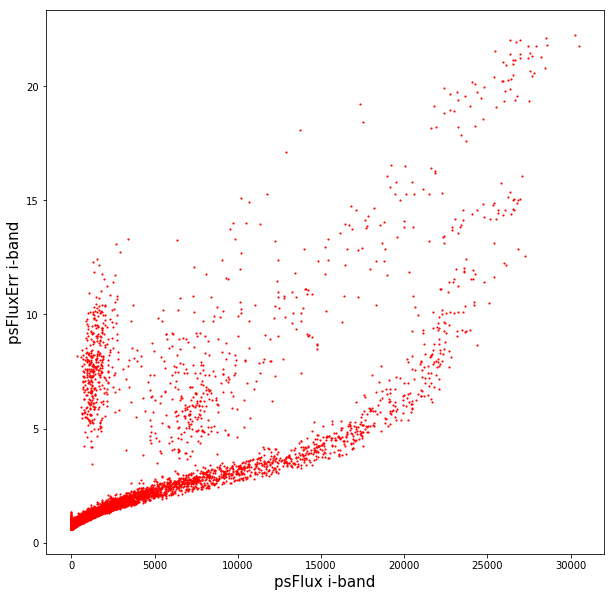

In [15]:
fig = plt.figure(figsize=(10,10))
plt.scatter(trimdata['psFlux_i'],trimdata['psFluxErr_i'],s=5,marker='.',c='r')
plt.xlabel("psFlux i-band",fontsize=15)
plt.ylabel("psFluxErr i-band",fontsize=15)

In [16]:
#psfmag = 22.5 - 2.5*np.log10(trimdata['psFlux_i']+1.e-22)
psfmag = 27 - 2.5*np.log10(trimdata['psFlux_i']+1.e-22)

Text(0,0.5,'mag_i_cModel')

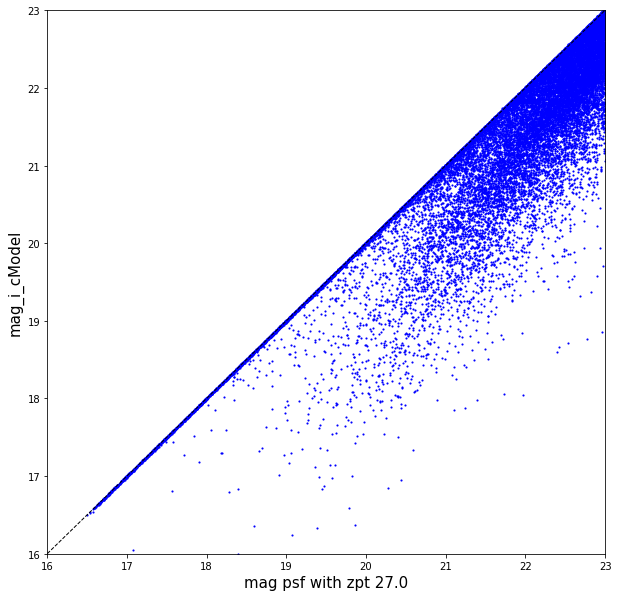

In [17]:
fig = plt.figure(figsize=(10,10))
plt.scatter(psfmag,trimdata['mag_i_cModel'],s=5,marker='.',c='b')
plt.plot([14,27],[14,27],lw=1,c='k',linestyle='--')
plt.xlim([16,23])
plt.ylim([16,23])
plt.xlabel("mag psf with zpt 27.0",fontsize=15)
plt.ylabel("mag_i_cModel",fontsize=15)

weird, looks like offset from nanomaggies is 27.0 instead of 22.5, don't know why?

Since fluxerr = 0.4*ln(10)*flux*mag_error, error in magnitude should just be <br> mag_err = psf_fluxerr/(0.4*ln(10)*flux), compute that

Now look at r-band:

In [18]:
r_psfmag = 27 - 2.5*np.log10(trimdata['psFlux_i']+1.e-22)

Text(0,0.5,'mag_r_cModel')

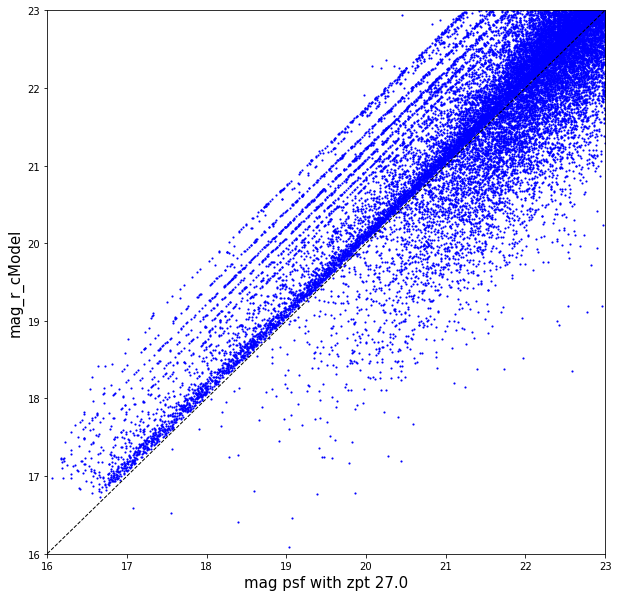

In [19]:
fig = plt.figure(figsize=(10,10))
plt.scatter(r_psfmag,trimdata['mag_r_cModel'],s=5,marker='.',c='b')
plt.plot([14,27],[14,27],lw=1,c='k',linestyle='--')
plt.xlim([16,23])
plt.ylim([16,23])
plt.xlabel("mag psf with zpt 27.0",fontsize=15)
plt.ylabel("mag_r_cModel",fontsize=15)

Looks strange!  Look into this later!  Maybe focus on cModel in model below for now...

In [20]:
psfmagerr = trimdata['psFluxErr_i']/(trimdata['psFlux_i']*0.921034)

Text(0,0.5,'mag_error (psf or cModel)')

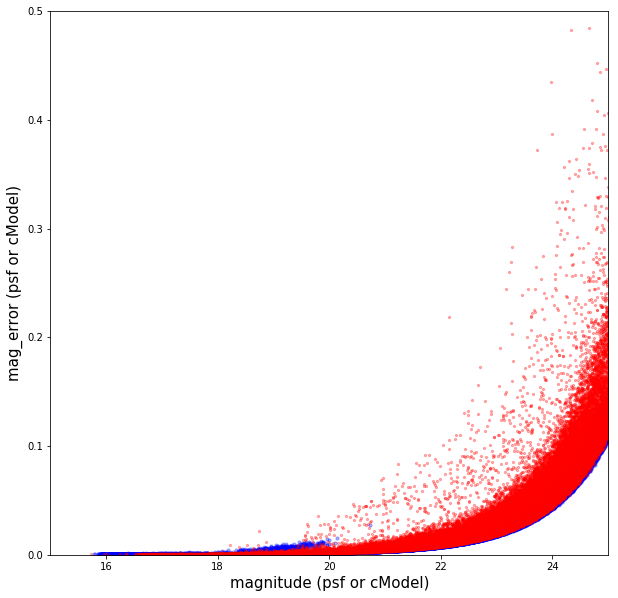

In [21]:
fig = plt.figure(figsize=(10,10))
plt.scatter(psfmag,psfmagerr,s=10,c='b',alpha=0.3)
plt.scatter(trimdata['mag_i_cModel'],trimdata['magerr_i_cModel'],s=5,c='r',alpha=0.3)
plt.xlim([15,25])
plt.ylim([0.,0.5])
#plt.ylim([-0.005,0.007])
plt.xlabel("magnitude (psf or cModel)",fontsize=15)
plt.ylabel("mag_error (psf or cModel)",fontsize=15)

In [22]:
starmask = (trimdata['extendedness']==0)
stars = trimdata[starmask]
xpsfmag = psfmag[starmask]
xpsfmagerr = psfmagerr[starmask]

Text(0.5,1,'magerr vs mag for stars')

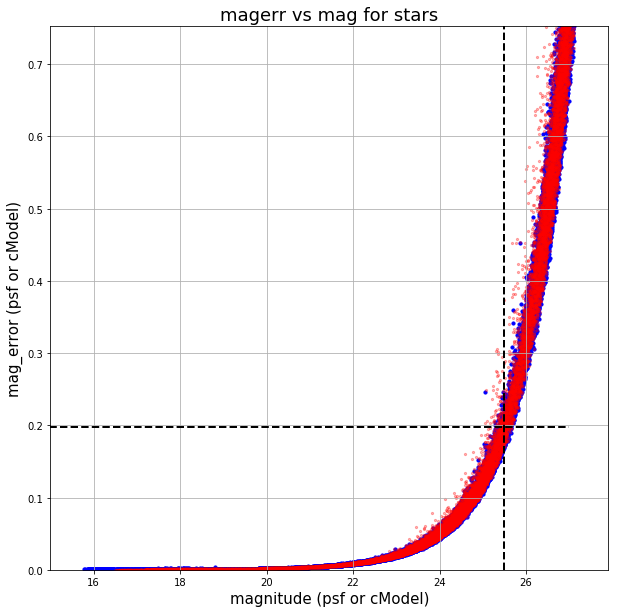

In [23]:
fig = plt.figure(figsize=(10,10))
plt.scatter(xpsfmag,xpsfmagerr,s=10,c='b')
plt.scatter(stars['mag_i_cModel'],stars['magerr_i_cModel'],s=5,c='r',alpha=0.3)
plt.plot([14,27],[0.1979,0.1979],lw=2,linestyle='--',c='k')
plt.plot([25.5,25.5],[0.,.8],lw=2,linestyle='--',c='k')
plt.xlim([15,27.9])
plt.ylim([0.,0.7525])
plt.grid()
#plt.ylim([-0.005,0.007])
plt.xlabel("magnitude (psf or cModel)",fontsize=15)
plt.ylabel("mag_error (psf or cModel)",fontsize=15)
plt.title("magerr vs mag for stars",fontsize=18)

1 sigma threshold is where <br>magerror~2.5log(2) = 0.7525, here ~27th mag<br>
5 sigma threshold is where <br>magerror~2.5log(1.2) = 0.1979, here ~25.5, in rough agreement with the number 25.7 for 5-sigma r-band listed on <br>
https://confluence.slac.stanford.edu/display/LSSTDESC/DC2+Data+Product+Overview

# Now test the LSST Zeljko error model

Use the same parameters that we used for DC1, taken from the Ivzic at all science drivers document.  For i-band 10 year depth is 184 30 second visits, use the fiducial airmass of 1.2, etc....

In [24]:
#Add the PhotoZDC1 package to the path and import photErrorModel that will be used to generate errors 
import sys
sys.path.insert(0, '/global/projecta/projectdirs/lsst/groups/PZ/PhotoZDC1/PhotoZDC1/src/')
import photErrorModel as errMod

In [25]:
errmodel = errMod.LSSTErrorModel()
errmodel.tvis = 30.0
errmodel.nYrObs=10.0
visits = {'LSST_u':5.6, 'LSST_g':8.0, 'LSST_r':18.4, 'LSST_i':18.4,'LSST_z':16.0,'LSST_y':16.0}

#visits = {'LSST_u':5.6, 'LSST_g':8.0, 'LSST_r':18.4, 'LSST_i':.15,'LSST_z':16.0,'LSST_y':16.0}

errmodel.nVisYr=visits
msky = {'LSST_u':22.99, 'LSST_g':22.26, 'LSST_r':21.20, 'LSST_i':20.48,'LSST_z':19.60,
        'LSST_y':18.61}
errmodel.msky = msky
#theta = {'LSST_u':0.81, 'LSST_g':0.77, 'LSST_r':0.73, 'LSST_i':0.71,'LSST_z':0.69,'LSST_y':0.68}
theta = {'LSST_u':0.92, 'LSST_g':0.87, 'LSST_r':0.83, 'LSST_i':0.80,'LSST_z':0.78,'LSST_y':0.76}
errmodel.theta = theta
gamma = {'LSST_u':0.038, 'LSST_g':0.039, 'LSST_r':0.039, 'LSST_i':0.039,'LSST_z':0.039,
         'LSST_y':0.039}
errmodel.gamma = gamma
#cm = {'LSST_u':23.09, 'LSST_g':24.42, 'LSST_r':24.44, 'LSST_i':24.32,'LSST_z':24.16,'LSST_y':23.73}
cmshift = {'LSST_u':22.47, 'LSST_g':24.24, 'LSST_r':24.34, 'LSST_i':24.25,'LSST_z':24.11,
           'LSST_y':23.69}
errmodel.Cm = cmshift
km = {'LSST_u':0.491, 'LSST_g':0.213, 'LSST_r':0.126, 'LSST_i':0.096,'LSST_z':0.069,'LSST_y':0.170}
errmodel.km = km
errmodel.airMass = 1.2
errmodel.extendedSource=0.0
errmodel.sigmaSys = 0.005
errmodel.__repr__

<bound method LSSTErrorModel.__repr__ of 
 LSSTErrorModel parameters:
 Exposure time = 30.0 s
 Number of years of observations = 10.0
 Number of visits per year per band: {'LSST_u': 5.6, 'LSST_g': 8.0, 'LSST_r': 18.4, 'LSST_i': 18.4, 'LSST_z': 16.0, 'LSST_y': 16.0}
 Systematic error = 0.005 mag
 Airmass = 1.2
 Sky brightness per band: {'LSST_u': 22.99, 'LSST_g': 22.26, 'LSST_r': 21.2, 'LSST_i': 20.48, 'LSST_z': 19.6, 'LSST_y': 18.61} (mag)
 Seeing per band: {'LSST_u': 22.99, 'LSST_g': 22.26, 'LSST_r': 21.2, 'LSST_i': 20.48, 'LSST_z': 19.6, 'LSST_y': 18.61} (arcsec)
 gamma per band: {'LSST_u': 0.038, 'LSST_g': 0.039, 'LSST_r': 0.039, 'LSST_i': 0.039, 'LSST_z': 0.039, 'LSST_y': 0.039}
 Cm per band: {'LSST_u': 22.47, 'LSST_g': 24.24, 'LSST_r': 24.34, 'LSST_i': 24.25, 'LSST_z': 24.11, 'LSST_y': 23.69}
 Extinction coeff. per band: {'LSST_u': 0.491, 'LSST_g': 0.213, 'LSST_r': 0.126, 'LSST_i': 0.096, 'LSST_z': 0.069, 'LSST_y': 0.17}
 Extended source model: add 0.0 mag to 5-sigma depth for poi

In [26]:
def makeSpline(grid,filt):
    fx =  [errmodel.getMagError(x,filt) for x in grid]
    return fx

In [27]:
#filts = ('LSST_u','LSST_g','LSST_r','LSST_i','LSST_z','LSST_y')
mag_min = 10.
mag_max = 45.
num_gridpts = 4001 #parameters for magerr_spline
mag_grid = np.linspace(mag_min,mag_max,num_gridpts)
grid_errs = makeSpline(mag_grid,'LSST_i')

#print (mag_grid)

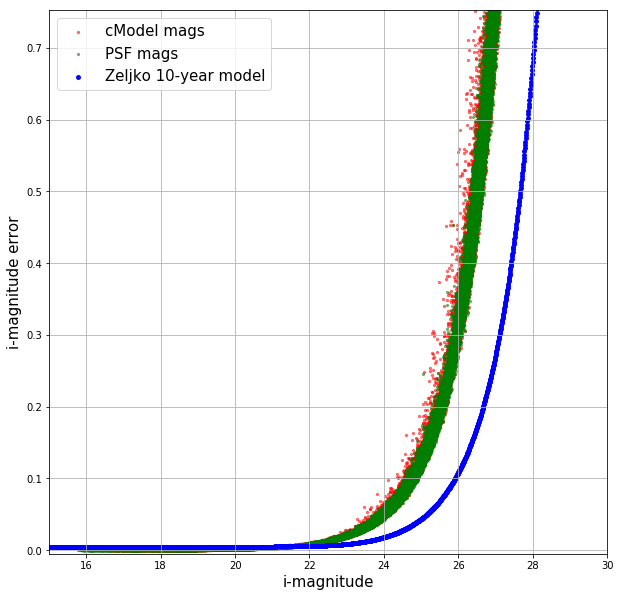

In [28]:
fig = plt.figure(figsize=(10,10))
plt.scatter(stars['mag_i_cModel'],stars['magerr_i_cModel'],s=5,c='r',alpha=0.5,label="cModel mags")
plt.scatter(xpsfmag,xpsfmagerr,s=5,c='g',alpha=0.5,label = "PSF mags")
plt.scatter(mag_grid,grid_errs,s=15,c='b',label="Zeljko 10-year model")
plt.xlim([15,30])
plt.ylim([-.005,.7525])
plt.grid()
plt.legend(loc='upper left',fontsize=15)
plt.xlabel("i-magnitude",fontsize=15)
plt.ylabel("i-magnitude error",fontsize=15)
plt.savefig("tract_4639_imagerr_test.jpg",fmt="jpg")

Much shallower than full-depth expectation.  <br>TODO: Look up how many stacked exposures went into the run1.2i stacks!

Plot S/N.  My rough number to keep in mind is that we expect S/N~30 for i~25 galaxies in full depth LSST, which is true for the 10 year model, see how off it is for 1.2i

Text(0,0.5,'cModel i S/N')

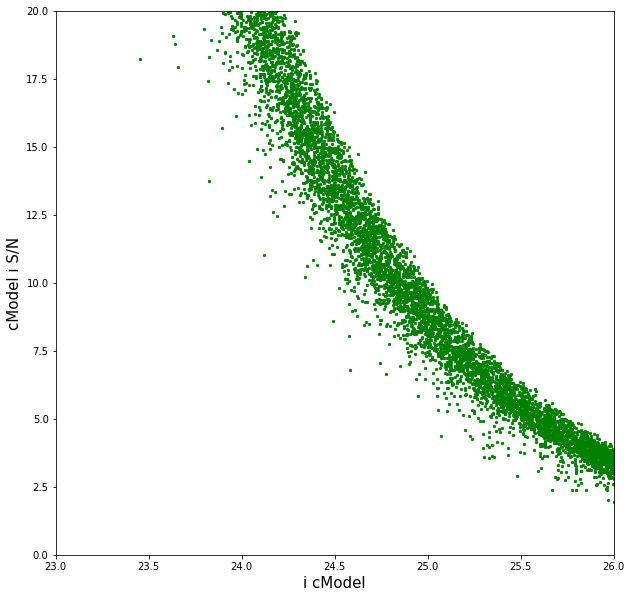

In [29]:
fig = plt.figure(figsize=(10,10))
plt.scatter(stars['mag_i_cModel'],stars['snr_i_cModel'],s=5,c='g')
plt.ylim([0,20])
plt.xlim([23,26])
plt.xlabel("i cModel",fontsize=15)
plt.ylabel("cModel i S/N",fontsize=15)

In [30]:
smgrid = [25.0,25.1,25.2,25.3,25.4]
print (makeSpline(smgrid,'LSST_i'))

[0.04340857499631831, 0.04752557300708762, 0.052044357171252206, 0.05700330372611248, 0.06244452196311514]


do a quick eyeball estimate of the number of visits by changing just that parameter in the fiducial Zeljko model, do 2 obs/year* 10 years = 20 total exposures

In [31]:
Xvisits = {'LSST_u':5.6, 'LSST_g':8.0, 'LSST_r':2.4, 'LSST_i':2.0,'LSST_z':16.0,'LSST_y':16.0}
Xerrmodel.nVisYr=Xvisits

<bound method LSSTErrorModel.__repr__ of 
 LSSTErrorModel parameters:
 Exposure time = 30.0 s
 Number of years of observations = 10.0
 Number of visits per year per band: {'LSST_u': 5.6, 'LSST_g': 8.0, 'LSST_r': 2.4, 'LSST_i': 2.0, 'LSST_z': 16.0, 'LSST_y': 16.0}
 Systematic error = 0.005 mag
 Airmass = 1.2
 Sky brightness per band: {'LSST_u': 22.99, 'LSST_g': 22.26, 'LSST_r': 21.2, 'LSST_i': 20.48, 'LSST_z': 19.6, 'LSST_y': 18.61} (mag)
 Seeing per band: {'LSST_u': 22.99, 'LSST_g': 22.26, 'LSST_r': 21.2, 'LSST_i': 20.48, 'LSST_z': 19.6, 'LSST_y': 18.61} (arcsec)
 gamma per band: {'LSST_u': 0.038, 'LSST_g': 0.039, 'LSST_r': 0.039, 'LSST_i': 0.039, 'LSST_z': 0.039, 'LSST_y': 0.039}
 Cm per band: {'LSST_u': 22.47, 'LSST_g': 24.24, 'LSST_r': 24.34, 'LSST_i': 24.25, 'LSST_z': 24.11, 'LSST_y': 23.69}
 Extinction coeff. per band: {'LSST_u': 0.491, 'LSST_g': 0.213, 'LSST_r': 0.126, 'LSST_i': 0.096, 'LSST_z': 0.069, 'LSST_y': 0.17}
 Extended source model: add 0.0 mag to 5-sigma depth for point

In [32]:
shallow_errs = [Xerrmodel.getMagError(x,'LSST_i') for x in mag_grid]

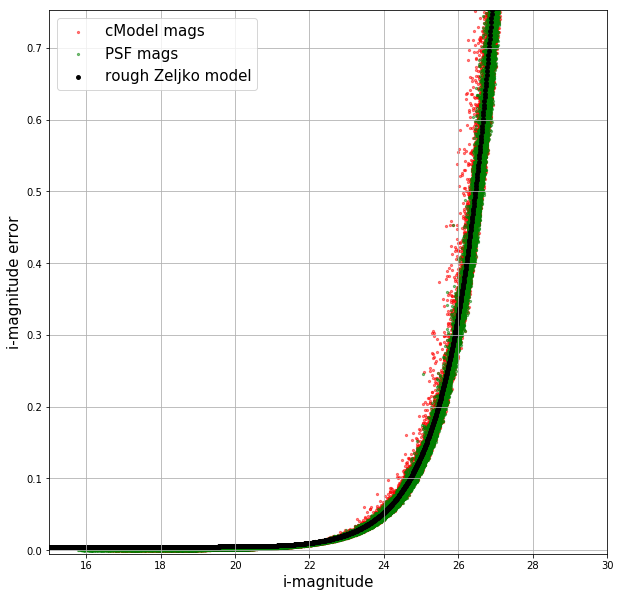

In [33]:
fig = plt.figure(figsize=(10,10))
plt.scatter(stars['mag_i_cModel'],stars['magerr_i_cModel'],s=5,c='r',alpha=0.5,label="cModel mags")
plt.scatter(xpsfmag,xpsfmagerr,s=5,c='g',alpha=0.5,label = "PSF mags")
plt.scatter(mag_grid,shallow_errs,s=15,c='k',label="rough Zeljko model")
plt.xlim([15,30])
plt.ylim([-.005,.7525])
plt.grid()
plt.legend(loc='upper left',fontsize=15)
plt.xlabel("i-magnitude",fontsize=15)
plt.ylabel("i-magnitude error",fontsize=15)
plt.savefig("tract_4639_imagerr_test.jpg",fmt="jpg")

Looks good!

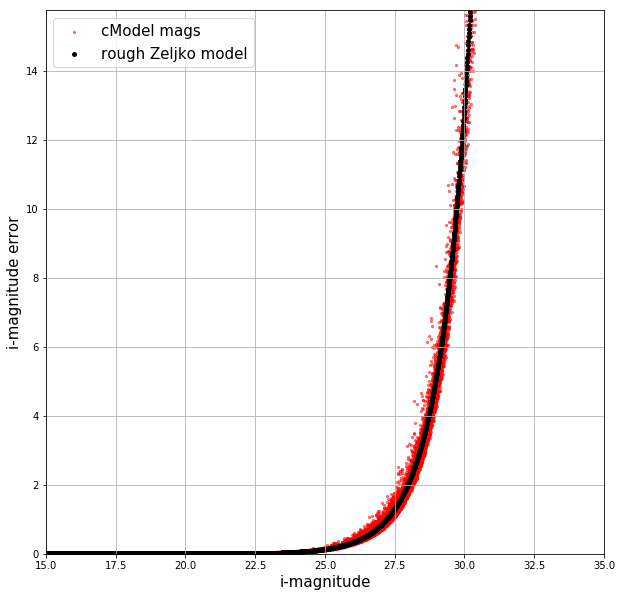

In [34]:
fig = plt.figure(figsize=(10,10))
plt.scatter(stars['mag_i_cModel'],stars['magerr_i_cModel'],s=5,c='r',alpha=0.5,label="cModel mags")
#plt.scatter(psfmag,psfmagerr,s=5,c='g',alpha=0.5,label = "PSF mags")
plt.scatter(mag_grid,shallow_errs,s=15,c='k',label="rough Zeljko model")
plt.xlim([15,35])
plt.ylim([-.005,15.7525])
plt.grid()
plt.legend(loc='upper left',fontsize=15)
plt.xlabel("i-magnitude",fontsize=15)
plt.ylabel("i-magnitude error",fontsize=15)
plt.savefig("tract_4639_imagerr_test.jpg",fmt="jpg")

Zeljko model errors rise much slower as a function of magnitude for this number of exposures!  Need to look into this more

Note: I believe Alex Abate and/or I tweaked something for low S/N that caused behavior like this, have to dig into notes to see if I can find it.

NOTE: after removing extra 2.5*log10(1+sigmaRand) term in photErrorModel.py in PhotoZDC1 code, this now matches very well with 20 exposures.  Check to see if 20 is, indeed, how many exposures are used in run1.2i for tract 4639.

Looking at the `'base_InputCount_value'` parameter in `deepCoadd_forced_src` table for tract number 4639, I see a broad range of contributing number of images, from 10 to 30; however, the distribution is bimodal, with peaks at 19 exposures and 24 exposures.  <br>
The mean number of exposures for all objects (with a cut for some bad flags to remove junk) is 20.8 images, and the median is 20.<br>
So, 20 stacked images is about right, and the Zeljko error model looks quite good!

# now check r-band

check for r-band, from the tract 4639 tables for "clean" objects, the distribution is more centrally peaked, and the mean exposure is 23.8 and the median is 24.  Let's compare the errors to the Zeljko model for 24 total exposures:

In [35]:
Xvisits = {'LSST_u':5.6, 'LSST_g':8.0, 'LSST_r':2.4, 'LSST_i':2.0,'LSST_z':16.0,'LSST_y':16.0}
Xerrmodel.nVisYr=Xvisits
r_shallow_errs = [Xerrmodel.getMagError(x,'LSST_r') for x in mag_grid]

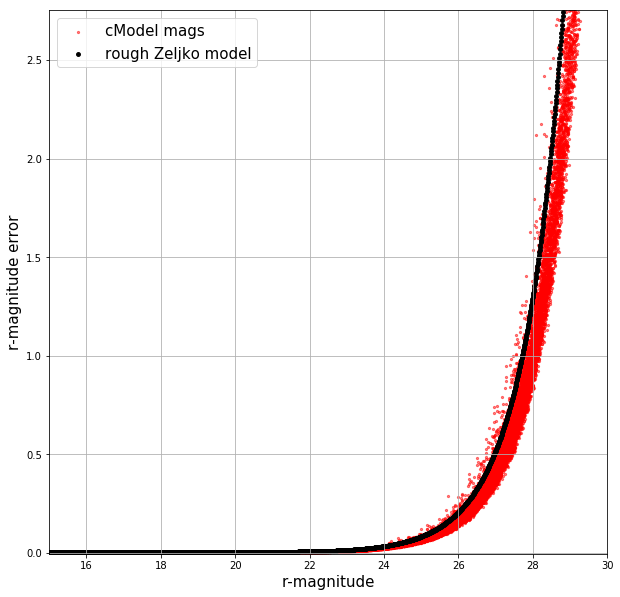

In [36]:
fig = plt.figure(figsize=(10,10))
plt.scatter(stars['mag_r_cModel'],stars['magerr_r_cModel'],s=5,c='r',alpha=0.5,label="cModel mags")
#plt.scatter(xpsfmag,xpsfmagerr,s=5,c='g',alpha=0.5,label = "PSF mags")
plt.scatter(mag_grid,r_shallow_errs,s=15,c='k',label="rough Zeljko model")
plt.xlim([15,30])
plt.ylim([-.005,2.7525])
plt.grid()
plt.legend(loc='upper left',fontsize=15)
plt.xlabel("r-magnitude",fontsize=15)
plt.ylabel("r-magnitude error",fontsize=15)
plt.savefig("tract_4639_rmagerr_test.jpg",fmt="jpg")

Off by quite a bit!  Try a slightly different number of visits

In [37]:
Xvisits = {'LSST_u':5.6, 'LSST_g':8.0, 'LSST_r':3.5, 'LSST_i':2.0,'LSST_z':16.0,'LSST_y':16.0}
Xerrmodel.nVisYr=Xvisits

In [38]:
r_shallow_errs2 = [Xerrmodel.getMagError(x,'LSST_r') for x in mag_grid]

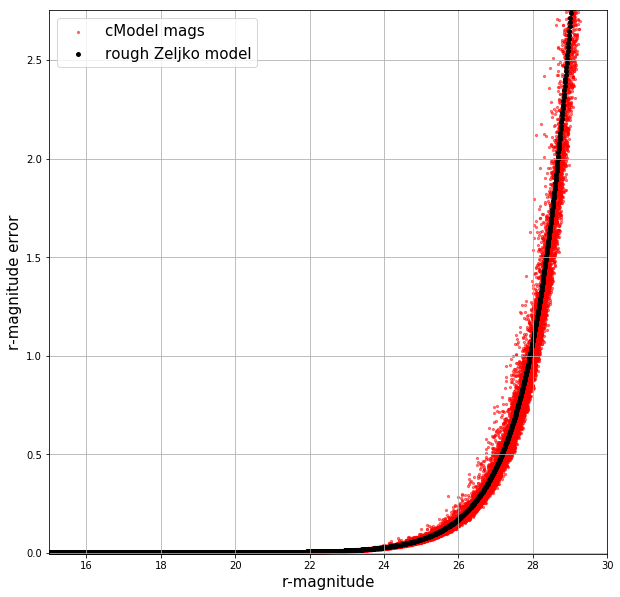

In [39]:
fig = plt.figure(figsize=(10,10))
plt.scatter(stars['mag_r_cModel'],stars['magerr_r_cModel'],s=5,c='r',alpha=0.5,label="cModel mags")
#plt.scatter(xpsfmag,xpsfmagerr,s=5,c='g',alpha=0.5,label = "PSF mags")
plt.scatter(mag_grid,r_shallow_errs2,s=15,c='k',label="rough Zeljko model")
plt.xlim([15,30])
plt.ylim([-.005,2.7525])
plt.grid()
plt.legend(loc='upper left',fontsize=15)
plt.xlabel("r-magnitude",fontsize=15)
plt.ylabel("r-magnitude error",fontsize=15)
plt.savefig("tract_4639_rmagerr_test.jpg",fmt="jpg")

Looks more like 35 visits rather than 24, quite a big difference.  Could it be differences in assumed airmass/sky brightness/seeing?

In [46]:
Xvisits = {'LSST_u':.4, 'LSST_g':8.0, 'LSST_r':3.5, 'LSST_i':2.0,'LSST_z':16.0,'LSST_y':16.0}
Xerrmodel.nVisYr=Xvisits
u_shallow_errs_low = [Xerrmodel.getMagError(x,'LSST_u') for x in mag_grid]
Xvisits = {'LSST_u':1., 'LSST_g':8.0, 'LSST_r':3.5, 'LSST_i':2.0,'LSST_z':16.0,'LSST_y':16.0}
Xerrmodel.nVisYr=Xvisits
u_shallow_errs_high = [Xerrmodel.getMagError(x,'LSST_u') for x in mag_grid]

In [44]:
#u_shallow_errs = [Xerrmodel.getMagError(x,'LSST_u') for x in mag_grid]

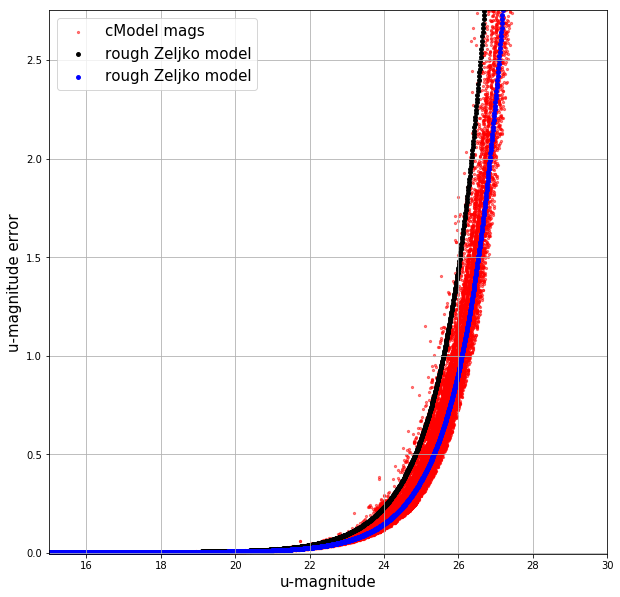

In [47]:
fig = plt.figure(figsize=(10,10))
plt.scatter(stars['mag_u_cModel'],stars['magerr_u_cModel'],s=5,c='r',alpha=0.5,label="cModel mags")
#plt.scatter(xpsfmag,xpsfmagerr,s=5,c='g',alpha=0.5,label = "PSF mags")
plt.scatter(mag_grid,u_shallow_errs_low,s=15,c='k',label="rough Zeljko model")
plt.scatter(mag_grid,u_shallow_errs_high,s=15,c='b',label="rough Zeljko model")
plt.xlim([15,30])
plt.ylim([-.005,2.7525])
plt.grid()
plt.legend(loc='upper left',fontsize=15)
plt.xlabel("u-magnitude",fontsize=15)
plt.ylabel("u-magnitude error",fontsize=15)
plt.savefig("tract_4639_umagerr_test.jpg",fmt="jpg")